In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm
import random

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from PIL import Image

In [2]:
# Apparently you may use different seed values at each stage
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O model_lightning.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('model_lightning')

fatal: destination path 'examples' already exists and is not an empty directory.


In [4]:
def detect(input_tensor, inference_count=3):

  image_height, image_width, channel = input_tensor.shape

  # Identify the subject in the entire image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly identify key points of the subject in the identified sub-area
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person


In [5]:
## DEFINITION OF THE DATASET PATH AND LIST WITH CATEGORY NAMES

# Directory to the data
DATASET_DIR = "../dataSet/"

# List with category names
all_classes_names = os.listdir('../dataSet/')
CLASSES_LIST = all_classes_names


In [6]:
# Initialization of constants for dimensions and number of frames per video

# First, define the new dimension to which to resize the frames.
# This choice is made to maintain the rectangular shape of the videos,
# and because larger dimensions could hinder the use of overly complex models
# due to the high memory usage.
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224

# define the number of frames to extract from each video.
# A higher number of frames will make the model more precise,
# but it also increases computational cost.
SEQUENCE_LENGTH = 10

# declaring threshold for detection 
detection_threshold = 0.1

# declaring the batch_size
#batch_size = 64

# epoch
# epochs = 150

In [7]:
def frames_extraction(video_path):
    # Initialize an empty list to store frames
    frames_list = []
    
    # Open the video file for reading
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    # Now, it is necessary to extract the total number of frames per video, as frames need to be extracted for the entire length of the video and not just at the beginning
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # This way, the video is divided into intervals of equal frames
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through a for loop that will select 10 frames per video, resize and normalize them individually,
    # and then add them to the previously initialized list
    for frame_counter in range(SEQUENCE_LENGTH):

        # This way, 10 frames are evenly selected across the entire video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Use the command to read the videos
        # Also define the *success* element because the read element has a boolean value as output
        # that provides the outcome of the procedure
        success, frame = video_reader.read() 

        # Check if the reading was successful, If the reading was not successful, break the loop
        if not success:
            return frames_list

        # Once the frames are extracted, they need to be resized to the chosen dimensions
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Convert the frame to RGB format and then to a tensor
        rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        image = tf.convert_to_tensor(frame)

        # Identify the subject's keypoints using the previously defined detect function
        person = detect(image)

        # Save the 17 keypoints and check if the minimum confidence threshold is exceeded for the keypoint with the lowest confidence
        min_landmark_score = min(
            [keypoint.score for keypoint in person.keypoints])
        should_keep_image = min_landmark_score >= detection_threshold

        if not should_keep_image:
            return frames_list

        # Save x and y coordinates and confidence for each keypoint
        pose_landmarks = np.array(
            [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
              for keypoint in person.keypoints],
            dtype = np.float32)
        
        coordinates = pose_landmarks.flatten().astype(str).tolist()

        # Add the frame to the list
        frames_list.append(coordinates)
    
    # As mentioned earlier, after each read, it is necessary to release the VideoCapture element so that it can be used on other videos 
    video_reader.release()

    # Return the list of frames
    return frames_list


In [8]:
def create_dataset():

    # Declare lists to store features, labels, and file paths
    features = []
    labels = []
    video_files_paths = []
    
    # Iterate through all classes in the CLASSES_LIST variable
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # List of videos in the specific class
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through the list of files in the class
        for file_name in files_list:
            
            # Extract the video path
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract frames from each video using the previously created function
            frames = frames_extraction(video_file_path)

            # Check that the extracted frames from each video match the SEQUENCE_LENGTH variable
            if len(frames) == SEQUENCE_LENGTH:

                # Add the extracted elements to their respective lists
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Return the frames, labels, and file paths
    return features, labels, video_files_paths


In [9]:
with tf.device('CPU:0'):
  features, labels, video_files_paths = create_dataset()

Extracting Data of Class: cartwheel


C:\Users\cspil\anaconda3\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\cspil\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Extracting Data of Class: clap
Extracting Data of Class: climbstairs
Extracting Data of Class: handstand
Extracting Data of Class: jump
Extracting Data of Class: pullup
Extracting Data of Class: pushup
Extracting Data of Class: run
Extracting Data of Class: situp
Extracting Data of Class: somersault
Extracting Data of Class: turn
Extracting Data of Class: walk


In [10]:
features = np.asarray(features)
labels = np.array(labels)

In [11]:
print(features)

[[['113.0' '73.0' '0.66088283' ... '110.0' '161.0' '0.85483146']
  ['105.0' '73.0' '0.56971264' ... '108.0' '158.0' '0.79080874']
  ['107.0' '67.0' '0.7166696' ... '108.0' '153.0' '0.7617853']
  ...
  ['193.0' '71.0' '0.513844' ... '188.0' '166.0' '0.5920764']
  ['137.0' '68.0' '0.5811192' ... '92.0' '165.0' '0.7497609']
  ['215.0' '73.0' '0.5047724' ... '205.0' '167.0' '0.6834769']]

 [['192.0' '79.0' '0.49193275' ... '187.0' '205.0' '0.2051097']
  ['192.0' '83.0' '0.42918873' ... '184.0' '205.0' '0.41358614']
  ['180.0' '68.0' '0.55907845' ... '167.0' '190.0' '0.6012492']
  ...
  ['95.0' '68.0' '0.43439975' ... '83.0' '169.0' '0.61756545']
  ['86.0' '80.0' '0.6290889' ... '83.0' '175.0' '0.43106']
  ['90.0' '71.0' '0.48490676' ... '104.0' '170.0' '0.80508614']]

 [['110.0' '114.0' '0.52532834' ... '117.0' '215.0' '0.75616926']
  ['118.0' '115.0' '0.43815866' ... '112.0' '213.0' '0.6612354']
  ['118.0' '118.0' '0.41984233' ... '99.0' '209.0' '0.84469867']
  ...
  ['155.0' '141.0' '0.5

In [12]:
print(labels)

[ 0  0  0  0  0  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11]


In [13]:
from collections import Counter

class_distribution = Counter(labels)
print("Class distribution:", class_distribution)

Class distribution: Counter({11: 78, 6: 41, 8: 27, 7: 23, 2: 22, 5: 22, 10: 17, 3: 16, 9: 13, 1: 7, 0: 5, 4: 5})


In [14]:
# Splitting the dataset into a Training (75%) and Testing (25%) partition.
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_value,
                                                                            stratify = labels)


In [15]:
import collections
collections.Counter(labels_train)

Counter({5: 16,
         6: 31,
         3: 12,
         11: 58,
         0: 4,
         2: 17,
         9: 10,
         4: 4,
         10: 13,
         7: 17,
         8: 20,
         1: 5})

In [16]:
one_hot_encoded_labels = tf.keras.utils.to_categorical(labels)

In [17]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_value,
                                                                            stratify = labels)


In [18]:
features_train = features_train.astype(float)
features_test = features_test.astype(float)

In [19]:
inputs = keras.Input(shape = (SEQUENCE_LENGTH, 51)) ## coordinate
x = inputs
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Bidirectional(keras.layers.LSTM(256, activation = 'tanh', return_sequences = True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(128,activation = 'tanh', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(12, activation='softmax')(x)
model = keras.Model(inputs = inputs, outputs = outputs)

# A parameter for Early Stopping is created, which stops the algorithm when the loss on the validation set does not decrease for more than 15 epochs.
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 15, mode = 'min', restore_best_weights = True)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])



In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 51)]          0         
                                                                 
 batch_normalization (Batch  (None, 10, 51)            204       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 10, 512)           630784    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               328192    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0     

In [21]:
LSTM_training_history = model.fit(x = features_train, y = labels_train, batch_size = 64, epochs = 150, 
                                  shuffle = True, callbacks = [early_stopping_callback], validation_data = (features_test, labels_test))
   

Epoch 1/150
4/4 [==============================] - 21s 1s/step - loss: 2.9887 - accuracy: 0.2754 - val_loss: 3.0076 - val_accuracy: 0.2899
Epoch 2/150
4/4 [==============================] - 1s 152ms/step - loss: 2.2785 - accuracy: 0.5362 - val_loss: 3.5751 - val_accuracy: 0.2899
Epoch 3/150
4/4 [==============================] - 1s 153ms/step - loss: 1.9501 - accuracy: 0.6039 - val_loss: 3.9765 - val_accuracy: 0.2899
Epoch 4/150
4/4 [==============================] - 1s 150ms/step - loss: 1.7512 - accuracy: 0.6715 - val_loss: 3.9476 - val_accuracy: 0.2899
Epoch 5/150
4/4 [==============================] - 1s 152ms/step - loss: 1.5927 - accuracy: 0.6860 - val_loss: 4.1919 - val_accuracy: 0.2899
Epoch 6/150
4/4 [==============================] - 1s 147ms/step - loss: 1.4709 - accuracy: 0.7391 - val_loss: 4.3997 - val_accuracy: 0.2899
Epoch 7/150
4/4 [==============================] - 1s 148ms/step - loss: 1.3771 - accuracy: 0.7536 - val_loss: 4.3070 - val_accuracy: 0.2899
Epoch 8/150
4/4

Epoch 59/150
4/4 [==============================] - 1s 145ms/step - loss: 0.3344 - accuracy: 0.9903 - val_loss: 1.6854 - val_accuracy: 0.7536
Epoch 60/150
4/4 [==============================] - 1s 144ms/step - loss: 0.3373 - accuracy: 0.9903 - val_loss: 1.6838 - val_accuracy: 0.7391
Epoch 61/150
4/4 [==============================] - 1s 150ms/step - loss: 0.2932 - accuracy: 0.9952 - val_loss: 1.6336 - val_accuracy: 0.7391
Epoch 62/150
4/4 [==============================] - 1s 150ms/step - loss: 0.3015 - accuracy: 0.9903 - val_loss: 1.6227 - val_accuracy: 0.7246
Epoch 63/150
4/4 [==============================] - 1s 154ms/step - loss: 0.2916 - accuracy: 1.0000 - val_loss: 1.6362 - val_accuracy: 0.7246
Epoch 64/150
4/4 [==============================] - 1s 139ms/step - loss: 0.2924 - accuracy: 0.9903 - val_loss: 1.5802 - val_accuracy: 0.7246
Epoch 65/150
4/4 [==============================] - 1s 143ms/step - loss: 0.2631 - accuracy: 1.0000 - val_loss: 1.5413 - val_accuracy: 0.7391
Epoch 

In [22]:
model_evaluation_history = model.evaluate(features_test, labels_test)

3/3 [==============================] - 0s 17ms/step - loss: 1.3548 - accuracy: 0.7826


In [23]:
loss = model_evaluation_history[0]
accuracy = model_evaluation_history[1]

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Loss: 1.3548
Test Accuracy: 78.26%


In [24]:
from keras.models import load_model
model.save('../Models/MoveNet_DEF.h5')

C:\Users\cspil\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
model.save('../Models/MoveNet_DEF.keras')

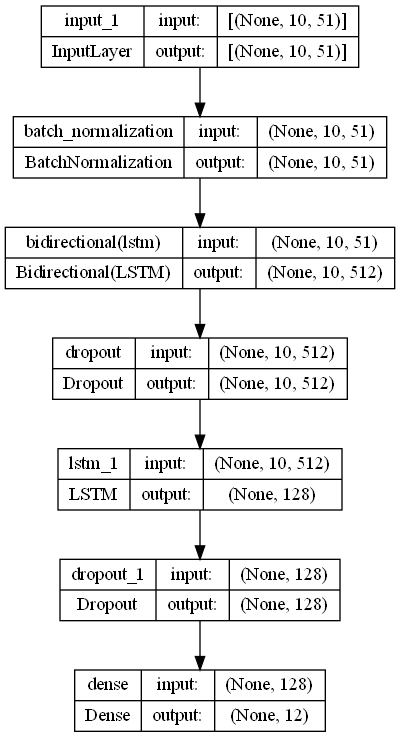

In [26]:
tf.keras.utils.plot_model(model, to_file = '../pipeline/MoveNet_model_structure_plot.png', show_shapes = True, show_layer_names = True)


In [27]:
!pip install pydotplus

In [28]:
!pip install pydot

In [29]:
conda install graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/msys2/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:

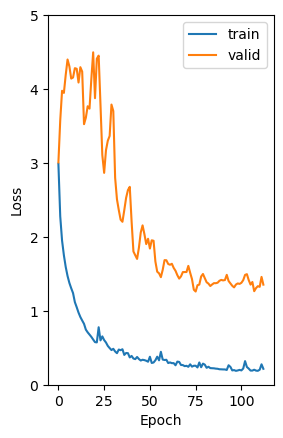

In [30]:
plt.subplot(1, 2, 1)
plt.plot(LSTM_training_history.history['loss'])
plt.plot(LSTM_training_history.history['val_loss'])
plt.ylim([0.0, 5.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

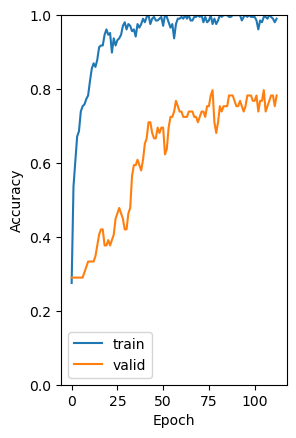

In [31]:
plt.subplot(1, 2, 2)
plt.plot(LSTM_training_history.history['accuracy'])
plt.plot(LSTM_training_history.history['val_accuracy'])
plt.ylim([0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [32]:
# Load the trained model
loaded_model = load_model('../Models/MoveNet_DEF.h5')

In [33]:
# Define constants for image dimensions
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
SEQUENCE_LENGTH = 10

In [34]:
# Create a list to store frames
frames_list = []

In [35]:
# Open the video file for reading
video_path = 'D:/MoveNet/sample_1.mp4'
video_reader = cv2.VideoCapture(video_path)

In [36]:
class_names = ["cartwheel", "clap",  "climbstairs", "handstand", "jump", "pullup", "pushup", "run", "situp", "somersault", "turn", "walk"]

In [37]:
while True:
    success, frame = video_reader.read()

    # If the reading was not successful or the frame is empty, break the loop
    if not success or frame is None:
        break

    # Resize the frame to the chosen dimensions
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Convert the frame to RGB format
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    
    # Convert the frame to a tensor and preprocess it
    image = tf.convert_to_tensor(rgb_frame)
    person = detect(image)

    # Save the 17 keypoints and check confidence
    min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
    should_keep_image = min_landmark_score >= detection_threshold

    if not should_keep_image:
        continue

    pose_landmarks = np.array(
        [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
          for keypoint in person.keypoints],
        dtype=np.float32)

    coordinates = pose_landmarks.flatten().astype(str).tolist()
    
    # Append the coordinates to the frames_list
    frames_list.append(coordinates)

    # If we have collected SEQUENCE_LENGTH frames, preprocess and predict
    if len(frames_list) == SEQUENCE_LENGTH:
        # Convert frames_list to a numpy array and add a batch dimension
        frames_array = np.array([frames_list], dtype = float)
        
        # Use the loaded model to predict the action
        predictions = loaded_model.predict(frames_array)
        
        # Post-process predictions to determine the action
        predicted_action = np.argmax(predictions)
        
        # Get the predicted class name based on the numeric label
        predicted_class_name = class_names[predicted_action]

        # Print or store the predicted class name
        print(f"Predicted Action: {predicted_class_name}")
        
        # Clear frames_list for the next sequence
        frames_list.clear()

# Release the video reader
video_reader.release()

1/1 [==============================] - 3s 3s/step
Predicted Action: turn
